In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Start
repo - https://github.com/peteryuX/retinaface-tf2

Dataset - http://shuoyang1213.me/WIDERFACE/

Training dataset download link - https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view

Validation dataset download link - https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view

RetinaFace official annotations - http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip

In [ ]:
import os
import cv2
import json
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

# Configuration

In [ ]:
cfg = {
'batch_size': 1,
'input_size': 640,
'backbone_type': 'MobileNetV2',  # 'ResNet50', 'MobileNetV2'
'sub_name': 'retinaface_mbv2',

# training dataset
'dataset_path': '/content/widerface_train_bin.tfrecord',
'dataset_len': 12880,  # number of training samples
'using_bin': True,            #using binary or not
'using_flip': True,
'using_distort': True,

# testing dataset
'testing_dataset_path': './data/widerface/val',

# network
'out_channel': 64,

# anchor setting
'min_sizes': [[16, 32], [64, 128], [256, 512]],
'steps': [8, 16, 32],
'match_thresh': 0.45,
'ignore_thresh': 0.3,
'variances': [0.1, 0.2],
'clip': False,

# training setting
'epoch': 1,
'init_lr': float(1e-2),
'lr_decay_epoch': [50, 68],
'lr_rate': 0.1,
'warmup_epoch': 5,
'min_lr': float(1e-3),

'weights_decay': float(5e-4),
'momentum': 0.9,

'pretrain': True,

'save_steps': 1000
}

# losses

In [ ]:
def _smooth_l1_loss(y_true, y_pred):
    t = tf.abs(y_pred - y_true)
    return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)


def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
    """multi-box loss"""
    def multi_box_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]

        loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
        landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
        class_pred = tf.reshape(y_pred[2], [num_batch * num_prior, num_class])

        loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
        landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
        landm_valid = tf.reshape(y_true[..., 14], [num_batch * num_prior, 1])
        class_true = tf.reshape(y_true[..., 15], [num_batch * num_prior, 1])

        # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
        #                     landm_valid = 1 (w landm), 0 (w/o landm)
        mask_pos = tf.equal(class_true, 1)
        mask_neg = tf.equal(class_true, 0)
        mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

        # landm loss (smooth L1)
        mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
        loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
                                     tf.boolean_mask(landm_pred, mask_landm_b))
        loss_landm = tf.reduce_mean(loss_landm)

        # localization loss (smooth L1)
        mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
        loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
                                   tf.boolean_mask(loc_pred, mask_pos_b))
        loss_loc = tf.reduce_mean(loss_loc)

        # classification loss (crossentropy)
        # 1. compute max conf across batch for hard negative mining
        loss_class = tf.where(mask_neg,
                              1 - class_pred[:, 0][..., tf.newaxis], 0)

        # 2. hard negative mining
        loss_class = tf.reshape(loss_class, [num_batch, num_prior])
        loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
        loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
        mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
        num_pos_per_batch = tf.reduce_sum(
                tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
        num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
        num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
                                       tf.cast(num_prior, tf.float32) - 1)
        mask_hard_neg = tf.reshape(
            tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
            [num_batch * num_prior, 1])

        # 3. classification loss including positive and negative examples
        loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
        loss_class_mask_b = tf.broadcast_to(loss_class_mask,
                                            tf.shape(class_pred))
        filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
                                            loss_class_mask)
        filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
        filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
        loss_class = tf.keras.losses.sparse_categorical_crossentropy(
            y_true=filter_class_true, y_pred=filter_class_pred)
        loss_class = tf.reduce_mean(loss_class)

        return loss_loc, loss_landm, loss_class

    return multi_box_loss

## lr_scheduler

In [ ]:
# def MultiStepLR(initial_learning_rate, lr_steps, lr_rate, name='MultiStepLR'):
#     """Multi-steps learning rate scheduler."""
#     lr_steps_value = [initial_learning_rate]
#     for _ in range(len(lr_steps)):
#         lr_steps_value.append(lr_steps_value[-1] * lr_rate)
#     return tf.keras.optimizers.schedules.PiecewiseConstantDecay(
#         boundaries=lr_steps, values=lr_steps_value)


# def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
#                       warmup_steps=0., min_lr=0.,
#                       name='MultiStepWarmUpLR'):
#     """Multi-steps warm up learning rate scheduler."""
#     assert warmup_steps <= lr_steps[0]
#     assert min_lr <= initial_learning_rate
#     lr_steps_value = [initial_learning_rate]
#     for _ in range(len(lr_steps)):
#         lr_steps_value.append(lr_steps_value[-1] * lr_rate)
#     return PiecewiseConstantWarmUpDecay(
#         boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
#         min_lr=min_lr)


# def CosineAnnealingLR_Restart(initial_learning_rate, t_period, lr_min):
#     """Cosine annealing learning rate scheduler with restart."""
#     return tf.keras.experimental.CosineDecayRestarts(
#         initial_learning_rate=initial_learning_rate,
#         first_decay_steps=t_period, t_mul=1.0, m_mul=1.0,
#         alpha=lr_min / initial_learning_rate)


# class PiecewiseConstantWarmUpDecay(
#         tf.keras.optimizers.schedules.LearningRateSchedule):
#     """A LearningRateSchedule wiht warm up schedule.
#     Modified from tf.keras.optimizers.schedules.PiecewiseConstantDecay"""

#     def __init__(self, boundaries, values, warmup_steps, min_lr,
#                  name=None):
#         super(PiecewiseConstantWarmUpDecay, self).__init__()

#         if len(boundaries) != len(values) - 1:
#             raise ValueError(
#                     "The length of boundaries should be 1 less than the"
#                     "length of values")

#         self.boundaries = boundaries
#         self.values = values
#         self.name = name
#         self.warmup_steps = warmup_steps
#         self.min_lr = min_lr

#     def __call__(self, step):
#         with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
#             step = tf.cast(tf.convert_to_tensor(step), tf.float32)
#             pred_fn_pairs = []
#             warmup_steps = self.warmup_steps
#             boundaries = self.boundaries
#             values = self.values
#             min_lr = self.min_lr

#             pred_fn_pairs.append(
#                 (step <= warmup_steps,
#                  lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
#             pred_fn_pairs.append(
#                 (tf.logical_and(step <= boundaries[0],
#                                 step > warmup_steps),
#                  lambda: tf.constant(values[0])))
#             pred_fn_pairs.append(
#                 (step > boundaries[-1], lambda: tf.constant(values[-1])))

#             for low, high, v in zip(boundaries[:-1], boundaries[1:],
#                                     values[1:-1]):
#                 pred = (step > low) & (step <= high)
#                 pred_fn_pairs.append((pred, lambda v=v: tf.constant(v)))

#             # The default isn't needed here because our conditions are mutually
#             # exclusive and exhaustive, but tf.case requires it.
#             return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
#                            exclusive=True)

#     def get_config(self):
#         return {
#                 "boundaries": self.boundaries,
#                 "values": self.values,
#                 "warmup_steps": self.warmup_steps,
#                 "min_lr": self.min_lr,
#                 "name": self.name
#         }


# if __name__ == "__main__":
#     lr_scheduler = MultiStepWarmUpLR(1e-2, [5500, 6800], 0.1,
#                                      warmup_steps=500, min_lr=1e-3)
#     # lr_scheduler = MultiStepWarmUpLR(1e-3, [5500, 6800], 0.1)
#     # lr_scheduler = MultiStepLR(1e-4, [500, 1000, 2000, 3000], 0.5)
#     # lr_scheduler = CosineAnnealingLR_Restart(2e-4, 2500, 1e-7)

#     ##############################
#     # Draw figure
#     ##############################
#     N_iter = 10000
#     step_list = list(range(0, N_iter, 10))
#     lr_list = []
#     for i in step_list:
#         current_lr = lr_scheduler(i).numpy()
#         lr_list.append(current_lr)

#     import matplotlib as mpl
#     from matplotlib import pyplot as plt
#     import matplotlib.ticker as mtick
#     mpl.style.use('default')
#     import seaborn
#     seaborn.set(style='whitegrid')
#     seaborn.set_context('paper')

#     plt.figure(1)
#     plt.subplot(111)
#     plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
#     plt.title('Title', fontsize=16, color='k')
#     plt.plot(step_list, lr_list, linewidth=1.5, label='learning rate scheme')
#     legend = plt.legend(loc='upper right', shadow=False)
#     ax = plt.gca()
#     labels = ax.get_xticks().tolist()
#     for k, v in enumerate(labels):
#         labels[k] = str(int(v / 1000)) + 'K'
#     ax.set_xticklabels(labels)
#     ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))

#     ax.set_ylabel('Learning rate')
#     ax.set_xlabel('Iteration')
#     fig = plt.gcf()
#     plt.show()

# Modified Model - only bbox and classification

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.layers import Input, Conv2D, ReLU, LeakyReLU, BatchNormalization

## Load Dataset from tfrecord and saving only bbox and class labels

In [ ]:
# # define prior box
# priors = prior_box((cfg['input_size'], cfg['input_size']),
#                     cfg['min_sizes'],  cfg['steps'], cfg['clip'])

# priors

In [ ]:
# priors.shape

(16800, 4)

In [ ]:
# # load dataset
# train_dataset = load_dataset(cfg, priors, shuffle=True)

In [ ]:
# from tqdm import tqdm
# steps_per_epoch = cfg['dataset_len'] // cfg['batch_size']
# steps_per_epoch

12880

In [ ]:
# for i,j in train_dataset.take(1):

#     data = i[0].numpy()
#     label = j[0].numpy()

#     print(data.shape)
#     print(label[:,[0,1,2,3,-2,-1]].shape)

#     print()
#     print(label[:,[0,1,2,3,-2,-1]])


(640, 640, 3)
(16800, 6)

[[ 3.1085504e+02  3.9293970e+02 -4.6967721e+00 -4.6967721e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.5542752e+02  1.9646985e+02 -8.1625080e+00 -8.1625080e+00
   0.0000000e+00  0.0000000e+00]
 [ 3.0585504e+02  3.9293970e+02 -4.6967721e+00 -4.6967721e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [-4.7322879e+00  3.7662681e-02 -1.8994764e+01 -1.8159508e+01
   0.0000000e+00  0.0000000e+00]
 [-1.6754894e+00  5.0284857e-01 -1.7788975e+01 -1.8559715e+01
   0.0000000e+00  0.0000000e+00]
 [-4.0136395e+00  1.5981196e-01 -1.8994780e+01 -1.8994780e+01
   0.0000000e+00  0.0000000e+00]]


In [ ]:
# idx = 1
# for i,j in tqdm(train_dataset.take(12880)):

#     data = i[0].numpy()
#     label = j[0].numpy()

#     label = label[:,[0,1,2,3,-2,-1]]

#     np.save(f'/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/{idx}.npy',
#             data)
#     np.save(f'/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/{idx}.npy',
#             label)

#     idx+=1


100%|██████████| 12880/12880 [22:33<00:00,  9.52it/s]


In [ ]:
# len(os.listdir('/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels'))

12880

In [ ]:
# len(dataset_list), len(label_list)

12880

In [ ]:
# dataset_numpy = np.array(dataset_list)

## Loading data from npys and making dataset

In [ ]:
data_folder = '/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/'
label_folder = '/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/'


In [ ]:
data_paths = [os.path.join(data_folder, i) for i in os.listdir(data_folder)]
label_paths = [os.path.join(label_folder, i) for i in os.listdir(label_folder)]

data_paths.sort()
label_paths.sort()

print(len(data_paths), len(label_paths))

print(data_paths[:3])
print(label_paths[:3])

12880 12880
['/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/1.npy', '/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/10.npy', '/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/100.npy']
['/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/1.npy', '/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/10.npy', '/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/100.npy']


In [ ]:
sample_input = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/1.npy', allow_pickle = True)
sample_output = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/1.npy', allow_pickle = True)

print(sample_input.shape)
print(sample_output.shape)

(640, 640, 3)
(16800, 6)


In [ ]:
(np.load(label_paths[0], allow_pickle = True))

array([[233.05553  ,  74.36275  ,   7.9080176,   9.265123 ,   1.       ,
          0.       ],
       [116.52776  ,  37.181374 ,   4.4422817,   5.7993875,   1.       ,
          0.       ],
       [228.05553  ,  74.36275  ,   7.9080176,   9.265123 ,   1.       ,
          0.       ],
       ...,
       [ -4.201389 ,  -9.785539 ,  -9.420662 ,  -8.063556 ,   1.       ,
          0.       ],
       [ -9.652778 , -19.571077 ,  -5.954926 ,  -4.59782  ,   1.       ,
          0.       ],
       [ -4.826389 ,  -9.785539 ,  -9.420662 ,  -8.063556 ,   1.       ,
          0.       ]], dtype=float32)

## Data Generator

In [ ]:
class Data_Generator(keras.utils.Sequence):
    """
    Helper function to iterate over the data (as Numpy arrays).
    """
 
    def __init__(self, batch_size, input_size, target_size, input_paths, target_paths):
        self.batch_size = batch_size
        self.input_size = input_size
        self.target_size = target_size
        self.input_paths = input_paths
        self.target_paths = target_paths
       
 
    def __len__(self):
        return len(self.target_paths) // self.batch_size                    # 12880//8
 
 
    def __getitem__(self, index):
        """
        Returns tuple (input, target) correspond to batch #index.
        """
 
        iterator = index * self.batch_size                                                            # 0
        batch_input_paths = self.input_paths[iterator : iterator + self.batch_size]                # [0: 0+8]
        batch_target_paths = self.target_paths[iterator : iterator + self.batch_size]
 
        x = np.zeros((self.batch_size,) + self.input_size, dtype="float32")           #(8,640,640,3)
        for j, path in enumerate(batch_input_paths):
            datapoint = np.load(path, allow_pickle = True) 
            x[j] = datapoint
 
        y = np.zeros((self.batch_size,) + self.target_size, dtype="float32")             #(8,16800,6)
        for j, path in enumerate(batch_target_paths):
            targetpoint = np.load(path, allow_pickle = True)                                                             #(500,500)
            y[j] = targetpoint                                                  #(16800,6)
 
        return x, y

In [ ]:
cfg

In [ ]:
# Gererator function
batch_size = 8
input_size = (640,640,3)
target_size = (16800,6)
 
train_gen = Data_Generator(batch_size, input_size, target_size, data_paths, label_paths)


In [ ]:
train_gen.__len__()

1610

In [ ]:
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

(8, 640, 640, 3) (8, 16800, 6)


## Model Architecture

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
input_size = (640,640,3)

In [ ]:
base_model = MobileNetV2(input_shape = input_size, include_top=False, weights= 'imagenet')

base_model.trainable = False



9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# base_model.summary()

In [ ]:
# base_model.layers[143].output

<KerasTensor: shape=(None, 20, 20, 960) dtype=float32 (created by layer 'block_16_expand')>

In [ ]:
# base_model.input

<KerasTensor: shape=(None, 640, 640, 3) dtype=float32 (created by layer 'input_2')>

In [ ]:
pick_layer1 = 54  # [80, 80, 192]
pick_layer2 = 116  # [40, 40, 576]
pick_layer3 = 143  # [20, 20, 960]

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# # define model
# inputs = Input(input_size, name='input_image')

# x = preprocess_input(inputs)
# mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)
# mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)
# mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)

# model = Model(inputs,
#               (mobilenetv2_layer1_80,
#                mobilenetv2_layer2_40,
#                mobilenetv2_layer3_20))

# model.summary()

In [ ]:
1518464 + 613952 + 65152 

2197568

In [ ]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)


# #model.save_weights('model.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# # load json and create model
# with open('model.json', 'r') as json_file:
#     model_json = json_file.read()

# model = tf.keras.models.model_from_json(model_json)
# # load weights into new model
# #model.load_weights("model.h5")

In [ ]:
# model.summary()

In [ ]:
def conv_block(prev_layer, name, filters, kernel, stride, act = True):
    x =  Conv2D(filters = filters, 
                kernel_size = kernel, 
                strides = stride, 
                padding='same',
                kernel_initializer = tf.keras.initializers.he_normal(),
                use_bias = False,
                name = name+'conv')(prev_layer)
    
    x = BatchNormalization(epsilon=1e-5,
                           name = name+'batchnorm')(x)

    if act:
        x = ReLU(name = name+'relu')(x)
               
    
    return x

In [ ]:
def fpn(input_layer1, input_layer2, input_layer3):
    output1 = conv_block(input_layer1,
                        'fpn1_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 80, 80, 64)
    
    output2 = conv_block(input_layer2,
                        'fpn2_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 40, 40, 64)
    
    output3 = conv_block(input_layer3,
                        'fpn3_',
                        filters = 64,
                        kernel = 1,
                        stride = 1)           #(None, 20, 20, 64)
    
    #Up sampling + feature fusion
    up_h2, up_w2 = tf.shape(output2)[1], tf.shape(output2)[2]         #up_h = 40, up_w = 40
    up3 = tf.image.resize(output3, [up_h2, up_w2], method='nearest')   # (None,40,40,64)
    output2 = output2 + up3                                                         # (None,40,40,64)


    merge2 = conv_block(output2,
                        'fpn2_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                                  # (None,40,40,64)
    

    #Up sampling + feature fusion
    up_h1, up_w1 = tf.shape(output1)[1], tf.shape(output1)[2]         #up_h = 80, up_w = 80
    up2 = tf.image.resize(merge2, [up_h1, up_w1], method='nearest')   # (None,80,80,64)
    output1 = output1 + up2                                                  # (None,80,80,64)


    merge1 = conv_block(output1,
                        'fpn1_merge_',
                        filters = 64,
                        kernel = 3,
                        stride = 1)                                               # (None,80,80,64)

                        
    return merge1, merge2, output3

In [ ]:
# o1,o2,o3 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

# print(o1)
# print(o2)
# print(o3)

In [ ]:
def ssh(prev_layer, name):
    conv_3x3 = conv_block(prev_layer,
                        name = name + 'conv_3x3',
                        filters = 64//2,
                        kernel = 3,
                        stride = 1,
                         act = False)      

    conv_5x5_1 = conv_block(prev_layer,
                        name = name + 'conv_5x5_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_5x5 = conv_block(conv_5x5_1,
                        name = name + 'conv_5x5',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)  

    conv_7x7_1 = conv_block(conv_5x5_1,
                        name = name + 'conv_7x7_1',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = True)  
    conv_7x7 = conv_block(conv_7x7_1,
                        name = name + 'conv_7x7',
                        filters = 64//4,
                        kernel = 3,
                        stride = 1,
                         act = False)    

    output = tf.concat([conv_3x3, conv_5x5, conv_7x7], axis=3)
    output = keras.layers.ReLU(name = name+'final_relu')(output)   

    return output

In [ ]:
# ssh2 = ssh(o2, 'ssh2_40_')

In [ ]:
# ssh2

<KerasTensor: shape=(None, 40, 40, 64) dtype=float32 (created by layer 'ssh2_40_final_relu')>

In [ ]:
min_sizes = [[16, 32], [64, 128], [256, 512]]
len(min_sizes)

3

In [ ]:
def classification_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 2, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 2])


def bbox_head(prev_layer, num_anchor, name):

    conv_1x1 = keras.layers.Conv2D(filters = num_anchor * 4, 
                                   kernel_size = 1, 
                                   strides = 1,
                                   name = name)(prev_layer)
    
    h, w = tf.shape(prev_layer)[1], tf.shape(prev_layer)[2]

    return tf.reshape(conv_1x1, [-1, h * w * num_anchor, 4])

In [ ]:
input_size

(640, 640, 3)

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# define model
inputs = Input(input_size, name='input_image')

x = preprocess_input(inputs)
mobilenetv2_layer1_80 = Model(base_model.input, base_model.layers[pick_layer1].output, name = 'mobilenet_layer54_80')(x)      #(None, 80, 80, 192)
mobilenetv2_layer2_40 = Model(base_model.input, base_model.layers[pick_layer2].output, name = 'mobilenet_layer116_40')(x)      #(None, 40, 40, 576)
mobilenetv2_layer3_20 = Model(base_model.input, base_model.layers[pick_layer3].output, name = 'mobilenet_layer143_20')(x)      #(None, 20, 20, 960)

#feature pyramid network
fpn_layer1_80, fpn_layer2_40, fpn_layer3_20 = fpn(mobilenetv2_layer1_80, mobilenetv2_layer2_40, mobilenetv2_layer3_20)

ssh_layer1 = ssh(fpn_layer1_80, name = 'ssh1_80_')
ssh_layer2 = ssh(fpn_layer2_40, name = 'ssh2_40_')
ssh_layer3 = ssh(fpn_layer3_20, name = 'ssh3_20_')

#Classification head
classification_layer1 = classification_head(ssh_layer1, len(min_sizes[0]), 'classification_layer1')
classification_layer2 = classification_head(ssh_layer2, len(min_sizes[0]), 'classification_layer2')
classification_layer3 = classification_head(ssh_layer3, len(min_sizes[0]), 'classification_layer3')

classifications = tf.concat([classification_layer1,
                             classification_layer2,
                             classification_layer3], axis=1)

#classification activation function 
classifications = tf.keras.layers.Softmax(axis = -1, name = 'classifications_softmax')(classifications)


#bounding box regressions head
bbox_layer1 = bbox_head(ssh_layer1, len(min_sizes[0]), 'bbox_layer1')
bbox_layer2 = bbox_head(ssh_layer2, len(min_sizes[0]), 'bbox_layer2')
bbox_layer3 = bbox_head(ssh_layer3, len(min_sizes[0]), 'bbox_layer3')

bbox_regressions = tf.concat([bbox_layer1,
                              bbox_layer2,
                              bbox_layer3], axis=1)

#output
output = (bbox_regressions, classifications)

model = Model(inputs, output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 640, 640, 3)  0           ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 640, 640, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 mobilenet_layer116_40 (Functio  (None, 40, 40, 576)  613952     ['tf.math.subtract[0][0]']   

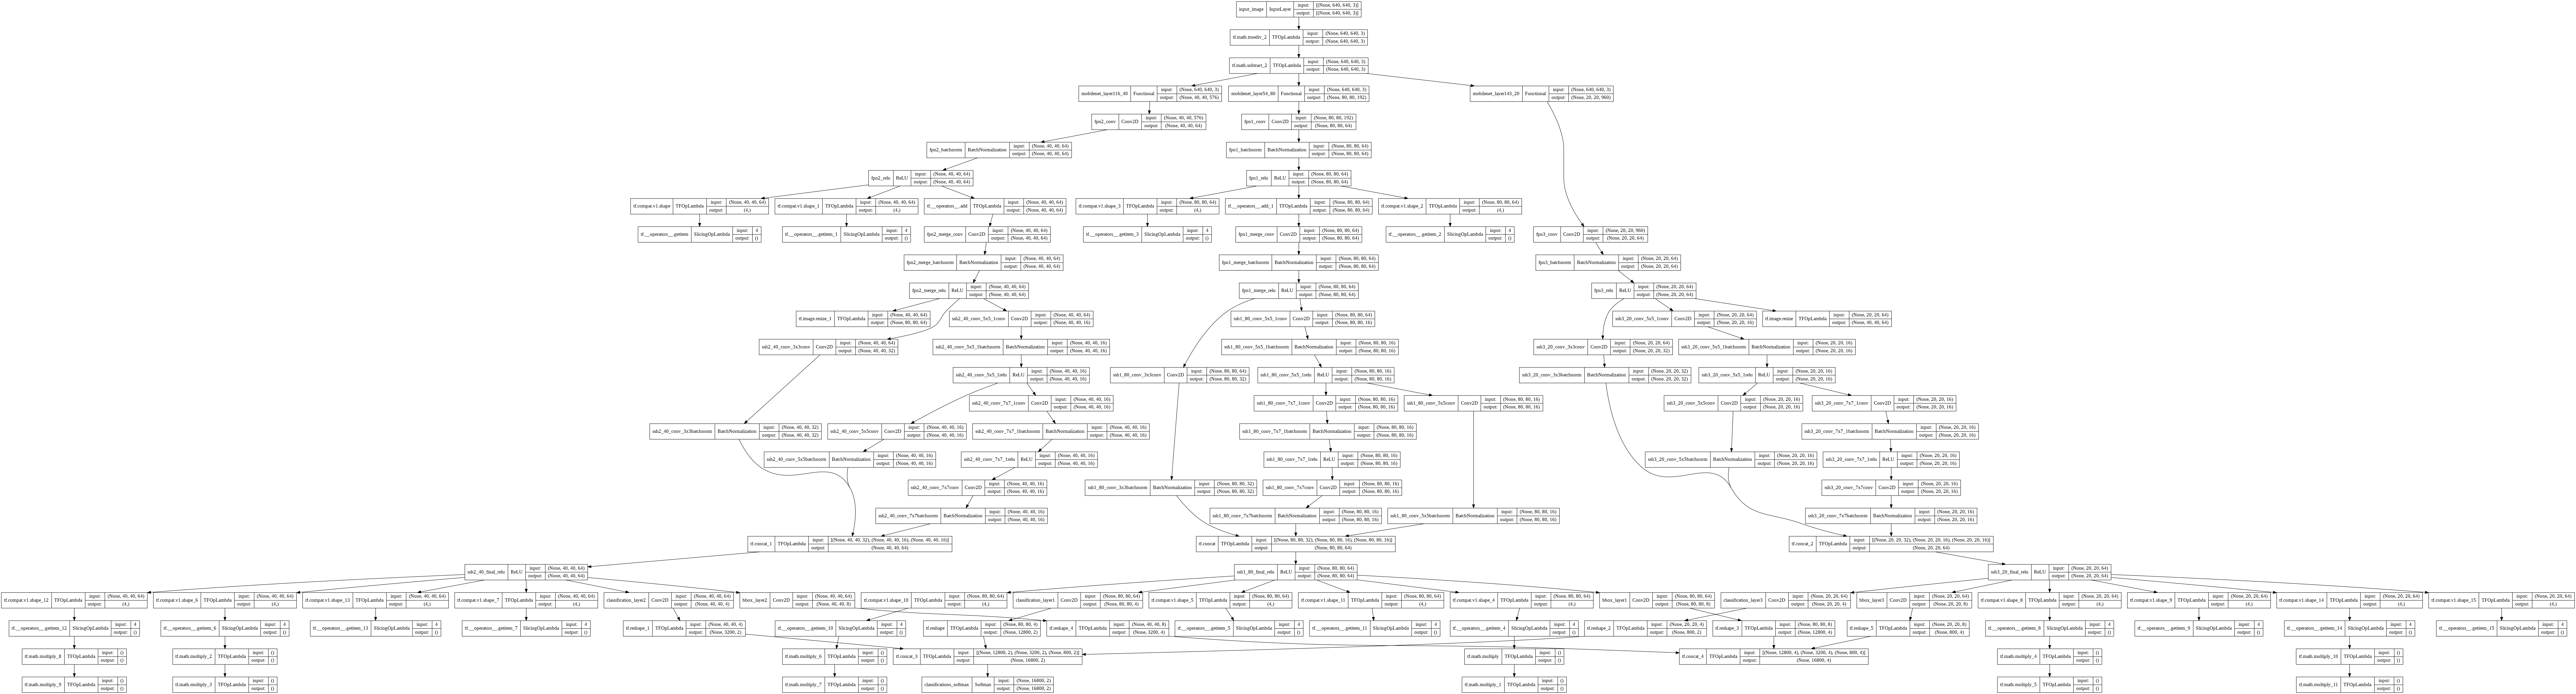

In [ ]:
tf.keras.utils.plot_model(model, 
                          to_file='/content/drive/MyDrive/RetinaFace/Modified/model_modified.png', 
                          show_shapes=True,
                          show_layer_names=True)

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified.json", "w") as json_file:
    json_file.write(model_json)


model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_withoutTraining.h5')


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
model.save("./saved_model/")

INFO:tensorflow:Assets written to: ./saved_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
x, y = train_gen.__getitem__(0)
print(x.shape, y.shape)

(8, 640, 640, 3) (8, 16800, 6)


In [ ]:
x[0].shape

(640, 640, 3)

In [ ]:
xtemp = np.expand_dims(x[0], 0)
xtemp.shape

(1, 640, 640, 3)

In [ ]:
ytemp = np.expand_dims(y[0], 0)
ytemp.shape

(1, 16800, 6)

In [ ]:
ypred_temp1 = model(xtemp)
ypred_temp1

(<tf.Tensor: shape=(1, 16800, 4), dtype=float32, numpy=
 array([[[ -4.3571877 ,   1.8523422 ,  -2.782684  ,   0.93465143],
         [ -0.4096757 ,   4.227859  ,  -3.357226  ,  -0.66821086],
         [ -4.5480757 ,  -0.98337877, -10.404079  ,  -0.0744141 ],
         ...,
         [ -1.841639  ,  -1.8042761 ,  -3.616313  ,   1.9591309 ],
         [ -0.971333  ,  -1.3116264 ,  -1.8186878 ,  -0.8024977 ],
         [ -1.6845682 ,  -1.318904  ,   1.2115103 ,  -1.1352222 ]]],
       dtype=float32)>, <tf.Tensor: shape=(1, 16800, 2), dtype=float32, numpy=
 array([[[9.9179709e-01, 8.2029412e-03],
         [8.4603125e-05, 9.9991536e-01],
         [9.9998808e-01, 1.1927764e-05],
         ...,
         [4.0768650e-01, 5.9231353e-01],
         [9.9874604e-01, 1.2539064e-03],
         [4.8307893e-01, 5.1692104e-01]]], dtype=float32)>)

In [ ]:
type(ypred_temp1)

tuple

In [ ]:
ypred_temp = list(ypred_temp1)
ypred_temp[0].shape, ypred_temp[1].shape

(TensorShape([1, 16800, 4]), TensorShape([1, 16800, 2]))

# Modified Model Training

## Defining losses

In [ ]:
def _smooth_l1_loss(y_true, y_pred):
    t = tf.abs(y_pred - y_true)
    return tf.where(t < 1, 0.5 * t ** 2, t - 0.5)


In [ ]:
def MultiBoxLoss(num_class=2, neg_pos_ratio=3):
    """multi-box loss

    y_pred: is tuple of 3 elements
    (TensorShape([1, 16800, 4]),   #bbox
     TensorShape([1, 16800, 10]),   #landm
     TensorShape([1, 16800, 2]))    #classification
    """
    def multi_box_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        num_prior = tf.shape(y_true)[1]

        #predictions
        loc_pred = tf.reshape(y_pred[0], [num_batch * num_prior, 4])
        #landm_pred = tf.reshape(y_pred[1], [num_batch * num_prior, 10])
        class_pred = tf.reshape(y_pred[1], [num_batch * num_prior, num_class])

        #ground truths
        loc_true = tf.reshape(y_true[..., :4], [num_batch * num_prior, 4])
        #landm_true = tf.reshape(y_true[..., 4:14], [num_batch * num_prior, 10])
        landm_valid = tf.reshape(y_true[..., 4], [num_batch * num_prior, 1])
        class_true = tf.reshape(y_true[..., 5], [num_batch * num_prior, 1])

        # define filter mask: class_true = 1 (pos), 0 (neg), -1 (ignore)
        #                     landm_valid = 1 (w landm), 0 (w/o landm)
        mask_pos = tf.equal(class_true, 1)
        mask_neg = tf.equal(class_true, 0)
        mask_landm = tf.logical_and(tf.equal(landm_valid, 1), mask_pos)

        '''# landm loss (smooth L1)
        mask_landm_b = tf.broadcast_to(mask_landm, tf.shape(landm_true))
        loss_landm = _smooth_l1_loss(tf.boolean_mask(landm_true, mask_landm_b),
                                     tf.boolean_mask(landm_pred, mask_landm_b))
        loss_landm = tf.reduce_mean(loss_landm)'''

        # localization loss (smooth L1)
        mask_pos_b = tf.broadcast_to(mask_pos, tf.shape(loc_true))
        loss_loc = _smooth_l1_loss(tf.boolean_mask(loc_true, mask_pos_b),
                                   tf.boolean_mask(loc_pred, mask_pos_b))
        loss_loc = tf.reduce_mean(loss_loc)

        # classification loss (crossentropy)
        # 1. compute max conf across batch for hard negative mining
        loss_class = tf.where(mask_neg,
                              1 - class_pred[:, 0][..., tf.newaxis], 0)

        # 2. hard negative mining
        loss_class = tf.reshape(loss_class, [num_batch, num_prior])
        loss_class_idx = tf.argsort(loss_class, axis=1, direction='DESCENDING')
        loss_class_idx_rank = tf.argsort(loss_class_idx, axis=1)
        mask_pos_per_batch = tf.reshape(mask_pos, [num_batch, num_prior])
        num_pos_per_batch = tf.reduce_sum(
                tf.cast(mask_pos_per_batch, tf.float32), 1, keepdims=True)
        num_pos_per_batch = tf.maximum(num_pos_per_batch, 1)
        num_neg_per_batch = tf.minimum(neg_pos_ratio * num_pos_per_batch,
                                       tf.cast(num_prior, tf.float32) - 1)
        mask_hard_neg = tf.reshape(
            tf.cast(loss_class_idx_rank, tf.float32) < num_neg_per_batch,
            [num_batch * num_prior, 1])

        # 3. classification loss including positive and negative examples
        loss_class_mask = tf.logical_or(mask_pos, mask_hard_neg)
        loss_class_mask_b = tf.broadcast_to(loss_class_mask,
                                            tf.shape(class_pred))
        filter_class_true = tf.boolean_mask(tf.cast(mask_pos, tf.float32),
                                            loss_class_mask)
        filter_class_pred = tf.boolean_mask(class_pred, loss_class_mask_b)
        filter_class_pred = tf.reshape(filter_class_pred, [-1, num_class])
        loss_class = tf.keras.losses.sparse_categorical_crossentropy(
            y_true=filter_class_true, y_pred=filter_class_pred)
        loss_class = tf.reduce_mean(loss_class)

        return loss_loc, loss_class

    return multi_box_loss

## Training

In [ ]:
steps_per_epoch =  train_gen.__len__()
steps_per_epoch

1610

In [ ]:
# define optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)


In [ ]:
# define losses function
multi_box_loss = MultiBoxLoss()

# define training step function
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs)

        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)
        losses['loc'], losses['class'] =  multi_box_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

In [ ]:
tl, l = train_step(xtemp, ytemp)

print(tl)
print(l)

tf.Tensor(16.031513, shape=(), dtype=float32)
{'reg': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'loc': <tf.Tensor: shape=(), dtype=float32, numpy=3.8730993>, 'class': <tf.Tensor: shape=(), dtype=float32, numpy=12.158415>}


In [ ]:
tl.numpy()

16.031513

In [ ]:
l['reg'].numpy(), l['loc'].numpy(), l['class'].numpy()

(0.0, 3.8730993, 12.158415)

In [ ]:
for i in range(0, steps_per_epoch+1):
  inputs,labels = train_gen.__getitem__(i)

  total_loss, losses = train_step(inputs, labels)

  print('Step number:',i)
  print(f'     Total loss: {total_loss.numpy()}')
  print(f'     reg loss: {losses["reg"].numpy()} loc/bbox loss: {losses["loc"].numpy()} class loss: {losses["class"].numpy()}')


print('Done')

model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_epoch1.h5')  




Step number: 0
     Total loss: 16.554729461669922
     reg loss: 0.0 loc/bbox loss: 4.277248382568359 class loss: 12.277482032775879
Step number: 1
     Total loss: 14.750594139099121
     reg loss: 0.0 loc/bbox loss: 3.2889013290405273 class loss: 11.461692810058594
Step number: 2
     Total loss: 15.344223022460938
     reg loss: 0.0 loc/bbox loss: 3.7128164768218994 class loss: 11.631406784057617
Step number: 3
     Total loss: 13.920832633972168
     reg loss: 0.0 loc/bbox loss: 3.0222065448760986 class loss: 10.898626327514648
Step number: 4
     Total loss: 13.016844749450684
     reg loss: 0.0 loc/bbox loss: 2.8012475967407227 class loss: 10.215597152709961
Step number: 5
     Total loss: 12.167563438415527
     reg loss: 0.0 loc/bbox loss: 2.4627630710601807 class loss: 9.704800605773926
Step number: 6
     Total loss: 12.597755432128906
     reg loss: 0.0 loc/bbox loss: 2.329706907272339 class loss: 10.268048286437988
Step number: 7
     Total loss: 10.851755142211914
     re

KeyboardInterrupt: ignored

In [ ]:
model.save_weights('/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_iterations518.h5')  

# Reading and testing model

In [ ]:
sample_input = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/data/1.npy', allow_pickle = True)
sample_output = np.load('/content/drive/MyDrive/RetinaFace/Dataset_numpy/labels/1.npy', allow_pickle = True)

print(sample_input.shape)
print(sample_output.shape)

(640, 640, 3)
(16800, 6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


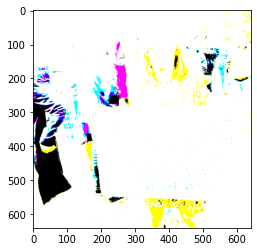

In [ ]:
plt.imshow(sample_input)
plt.show()

In [ ]:
sample_input = np.expand_dims(sample_input,0)
sample_output = np.expand_dims(sample_output,0)

print(sample_input.shape)
print(sample_output.shape)

(1, 640, 640, 3)
(1, 16800, 6)


In [ ]:
# load json and create model
with open("/content/drive/MyDrive/RetinaFace/Modified/model_modified.json", 'r') as json_file:
    model_json = json_file.read()

# load weights into new model
loaded_model = tf.keras.models.model_from_json(model_json)
loaded_model.load_weights("/content/drive/MyDrive/RetinaFace/Modified/model_modified_Training_iterations518.h5")

In [ ]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 640, 640, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_2 (TFOpLambda)  (None, 640, 640, 3)  0          ['input_image[0][0]']            
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 640, 640, 3)  0          ['tf.math.truediv_2[0][0]']      
 )                                                                                                
                                                                                              

In [ ]:
sample_input_8, sample_output_8 = train_gen.__getitem__(1600)

print(sample_input_8.shape)
print(sample_output_8.shape)

(8, 640, 640, 3)
(8, 16800, 6)


In [ ]:
%timeit -n5 2+3

5 loops, best of 5: 65.2 ns per loop


In [ ]:
%timeit -n5 loaded_model(sample_input)

5 loops, best of 5: 203 ms per loop


In [ ]:
# #for 1 sample
# sample_pred = loaded_model(sample_input)
# sample_pred

In [ ]:
#for 1 sample
sample_pred = loaded_model(sample_input_8)
sample_pred

In [ ]:
type(sample_pred)

list

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output_8, sample_pred)

print(a)
print(b)

tf.Tensor(0.66464496, shape=(), dtype=float32)
tf.Tensor(0.6271524, shape=(), dtype=float32)


In [ ]:
loaded_model.save("/content/drive/MyDrive/RetinaFace/Modified/saved_model")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/RetinaFace/Modified/saved_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# Quantization

## tflite - **Without quantization**

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model")
# tflite_model = converter.convert()

In [ ]:
# open("/content/drive/MyDrive/RetinaFace/Modified/model_without_quant.tflite", "wb").write(tflite_model)

7388124

In [ ]:
type(tflite_model)

bytes

In [ ]:
len(tflite_model)

7388124

In [ ]:
len(tflite_model)/1000_000

7.388124

In [ ]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/RetinaFace/Modified/model_without_quant.tflite")
interpreter.allocate_tensors()

In [ ]:
dir(interpreter)

In [ ]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 274,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
sample_input.shape, sample_output.shape

(1, 640, 640, 3)

In [ ]:
# Test model on input data.
interpreter.set_tensor(input_details[0]['index'], sample_input)

interpreter.invoke()

In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data1 = interpreter.get_tensor(output_details[0]['index'])
output_data2 = interpreter.get_tensor(output_details[1]['index'])

In [ ]:
print(output_data1)

[[[-0.4127545  -1.5728643  -4.55903    -0.40923747]
  [ 1.0854273   2.4942153  -0.08976269  0.52290875]
  [-1.7849374  -2.0133815  -4.6762466  -0.5943247 ]
  ...
  [-0.91692156 -0.02157185 -3.8568854   1.1739311 ]
  [-1.598427    1.6633886  -3.3484266  -1.3257116 ]
  [ 1.5555371  -0.44120577 -0.30481085 -2.481168  ]]]


In [ ]:
output_data1.shape

(1, 16800, 4)

In [ ]:
print(output_data2)

[[[9.9712592e-01 2.8740240e-03]
  [9.8324353e-01 1.6756468e-02]
  [9.9881989e-01 1.1800369e-03]
  ...
  [9.9446493e-01 5.5350387e-03]
  [9.9984455e-01 1.5542649e-04]
  [9.9450994e-01 5.4900032e-03]]]


In [ ]:
output_data2.shape

(1, 16800, 2)

In [ ]:
out_pred = [output_data1, output_data2]

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output, out_pred)

print(a)
print(b)

tf.Tensor(0.7543104, shape=(), dtype=float32)
tf.Tensor(0.63122994, shape=(), dtype=float32)


In [ ]:
sample_input_8.shape, sample_output_8.shape

((8, 640, 640, 3), (8, 16800, 6))

In [ ]:
# Test model on input data.
a,b = [],[]
for i,o in zip(sample_input_8, sample_output_8):
  
  i = np.expand_dims(i,0)
  o = np.expand_dims(o,0)
  # print(i.shape, o.shape)

  interpreter.set_tensor(input_details[0]['index'], i)

  interpreter.invoke()

  output_data1 = interpreter.get_tensor(output_details[0]['index'])
  output_data2 = interpreter.get_tensor(output_details[1]['index'])

  out_pred = [output_data1,output_data2]
  multi_box_loss = MultiBoxLoss()
  a1,b1 =  multi_box_loss(o, out_pred)

  a.append(a1.numpy())
  b.append(b1.numpy())

print(a)
print(b)

[0.53056425, 0.554074, 0.6654744, 0.7382624, 0.68064374, 0.63030267, 0.77537036, 0.657935]
[0.5774213, 0.69606584, 0.5569685, 0.9320228, 0.7084929, 0.9715259, 0.53438646, 0.58873725]


In [ ]:
np.mean(a), np.mean(b)

(0.65407836, 0.6957026)

## tflite - **With quantization**

In [ ]:
# converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/MyDrive/RetinaFace/Modified/saved_model")
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# tflite_quant_model = converter.convert()

In [ ]:
# open("/content/drive/MyDrive/RetinaFace/Modified/model_with_quant.tflite", "wb").write(tflite_quant_model)

2273376

In [ ]:
type(tflite_quant_model)

bytes

In [ ]:
len(tflite_quant_model)

2273376

In [ ]:
len(tflite_quant_model)/1000_000

2.273376

In [ ]:
# Load TFLite model and allocate tensors.
quant_interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/RetinaFace/Modified/model_with_quant.tflite")
quant_interpreter.allocate_tensors()

In [ ]:
# Get input and output tensors.
input_details = quant_interpreter.get_input_details()
output_details = quant_interpreter.get_output_details()

In [ ]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_image:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 640, 640,   3], dtype=int32),
  'shape_signature': array([ -1, 640, 640,   3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
output_details

[{'dtype': numpy.float32,
  'index': 274,
  'name': 'StatefulPartitionedCall:1',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     4], dtype=int32),
  'shape_signature': array([   -1, 16800,     4], dtype=int32),
  'sparsity_parameters': {}},
 {'dtype': numpy.float32,
  'index': 277,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([    1, 16800,     2], dtype=int32),
  'shape_signature': array([   -1, 16800,     2], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
sample_input.shape, sample_output.shape

((1, 640, 640, 3), (1, 16800, 6))

In [ ]:
# Test model on input data.
quant_interpreter.set_tensor(input_details[0]['index'], sample_input)

quant_interpreter.invoke()

In [ ]:
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data1 = quant_interpreter.get_tensor(output_details[0]['index'])
output_data2 = quant_interpreter.get_tensor(output_details[1]['index'])

In [ ]:
output_data1

array([[[-0.2147151 , -1.5301219 , -4.695122  , -0.33596018],
        [ 1.1926262 ,  2.5578892 , -0.16545063,  0.44747844],
        [-1.6476488 , -2.0478158 , -4.8182316 , -0.5191489 ],
        ...,
        [-0.86458427,  0.04930546, -3.3551204 ,  1.0508697 ],
        [-1.6168034 ,  1.6842387 , -3.1889796 , -1.5622228 ],
        [ 1.2766899 , -0.42298612, -0.43460312, -2.3010695 ]]],
      dtype=float32)

In [ ]:
output_data1.shape

(1, 16800, 4)

In [ ]:
output_data2

array([[[9.9674845e-01, 3.2515377e-03],
        [9.8148304e-01, 1.8516907e-02],
        [9.9898404e-01, 1.0158819e-03],
        ...,
        [9.9477732e-01, 5.2226670e-03],
        [9.9983633e-01, 1.6361907e-04],
        [9.9378455e-01, 6.2153959e-03]]], dtype=float32)

In [ ]:
output_data2.shape

(1, 16800, 2)

In [ ]:
out_pred = [output_data1, output_data2]

In [ ]:
multi_box_loss = MultiBoxLoss()
a,b =  multi_box_loss(sample_output, out_pred)

print(a)
print(b)

tf.Tensor(0.75760704, shape=(), dtype=float32)
tf.Tensor(0.62759566, shape=(), dtype=float32)


In [ ]:
# Test model on input data.
a,b = [],[]
for i,o in zip(sample_input_8, sample_output_8):
  
  i = np.expand_dims(i,0)
  o = np.expand_dims(o,0)
  # print(i.shape, o.shape)

  quant_interpreter.set_tensor(input_details[0]['index'], i)

  quant_interpreter.invoke()

  output_data1 = quant_interpreter.get_tensor(output_details[0]['index'])
  output_data2 = quant_interpreter.get_tensor(output_details[1]['index'])

  out_pred = [output_data1,output_data2]
  multi_box_loss = MultiBoxLoss()
  a1,b1 =  multi_box_loss(o, out_pred)

  a.append(a1.numpy())
  b.append(b1.numpy())

print(a)
print(b)

[0.52375275, 0.57747203, 0.66809577, 0.73226124, 0.66585845, 0.60367453, 0.7603623, 0.6510843]
[0.56775963, 0.6796008, 0.5574069, 0.969025, 0.7039156, 0.98445714, 0.5308236, 0.59427595]


In [ ]:
np.mean(a), np.mean(b)

(0.6478201, 0.69840807)

# END